# CTU - 13: Exploratory Data Analysis

Performing EDA on the dataset in this notebook.

Below is my plan:
1. Correlation of the features and its heatmap
2. Pairplot between highly correlated features.
3. For all the categorial or columns with small number of unique values, countplot or barplot of those features.
4. For any numerical features, plot pdf

## Importing libraries

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
# from prettytable import PrettyTable  # To print in tabular format
import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

## Loading data from disk

In [2]:
train = pd.read_csv('./train_alldata_EDA.csv')

In [3]:
test = pd.read_csv('./test_alldata_EDA.csv')

In [4]:
train.shape, test.shape

((9950992, 17), (4271468, 17))

In [5]:
len(train)

9950992

In [6]:
train.drop(columns='Unnamed: 0', axis=1, inplace=True)
test.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [7]:
train.head()

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label,target
0,2011-08-12 22:08:41.277072,0.000000,tcp,74.86.42.203,80,->,147.32.86.50,3072,SA_,0.0,0.0,1,60,60,flow=Background-TCP-Established,0
1,2011-08-14 23:11:07.462572,0.003940,udp,67.49.33.55,53622,<->,147.32.84.229,13363,CON,0.0,0.0,4,2995,60,flow=Background-UDP-Established,0
2,2011-08-15 14:02:41.946307,0.000289,udp,147.32.86.171,56559,<->,147.32.80.9,53,CON,0.0,0.0,2,392,77,flow=To-Background-UDP-CVUT-DNS-Server,0
3,2011-08-16 08:46:24.544795,1336.481934,udp,77.87.33.112,35057,<->,147.32.84.229,13363,CON,0.0,0.0,4,1138,150,flow=Background-UDP-Established,0
4,2011-08-18 10:41:28.980563,0.984197,tcp,84.122.159.122,1958,->,147.32.84.118,6881,S_RA,0.0,0.0,6,366,186,flow=Background-TCP-Attempt,0


In [8]:
# Dividing the train data into attack and non-attack category
normal = train[train['target']==0]
anomaly = train[train['target']==1]

In [9]:
normal.shape, anomaly.shape

((9694069, 16), (256923, 16))

## Correlation
Getting correlation values for all the features.

Plot heatmap of correaltion for better visualization

### Utility functions

In [10]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [11]:
def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

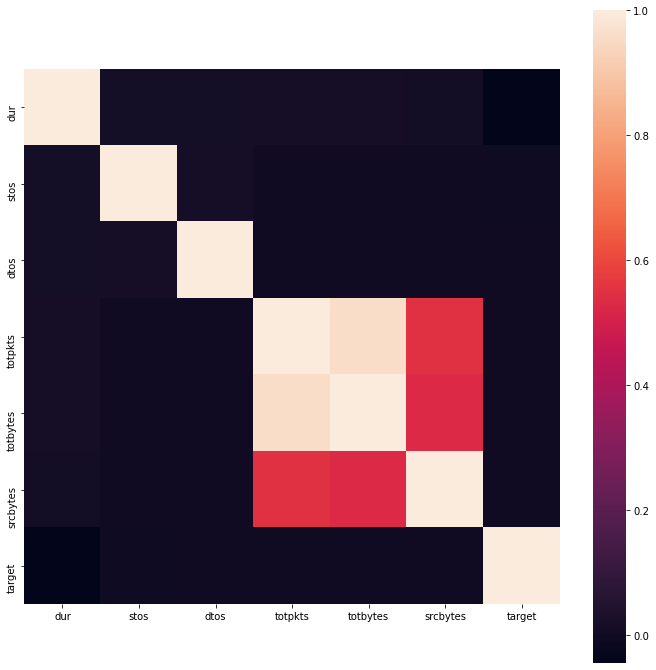

In [12]:
# Plotting the correlation matrix of numerical feature in dataset

method = "pearson"
# correlation matrix
corr_mat = train.corr(method=method)

plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

In [13]:
corr_mat.columns.shape

(7,)

In [14]:
# Getting and printing high correlated features
limit = 0.5

columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= limit:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")


totpkts              totbytes             0.9610826457599371
totpkts              srcbytes             0.5496502723652984
totbytes             srcbytes             0.5281981236371139


Most correlated features are:
* totpkts, totbytes



## Pairplots of highly correlated features

### totpkts and totbytes

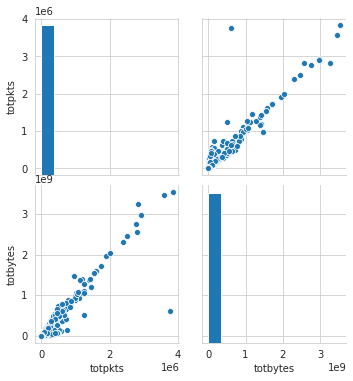

In [15]:
sns.set_style("whitegrid")
sns.pairplot(data=train, vars=['totpkts', 'totbytes'])
plt.show()

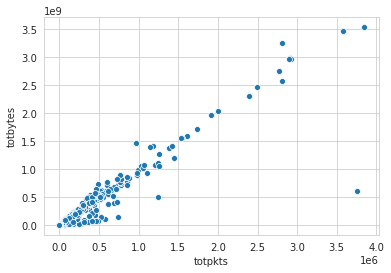

In [16]:
sns.scatterplot(x='totpkts', y='totbytes', data=train)

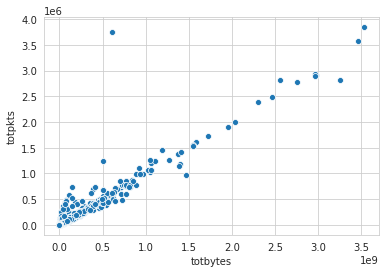

In [17]:
sns.scatterplot(x='totbytes', y='totpkts', data=train)

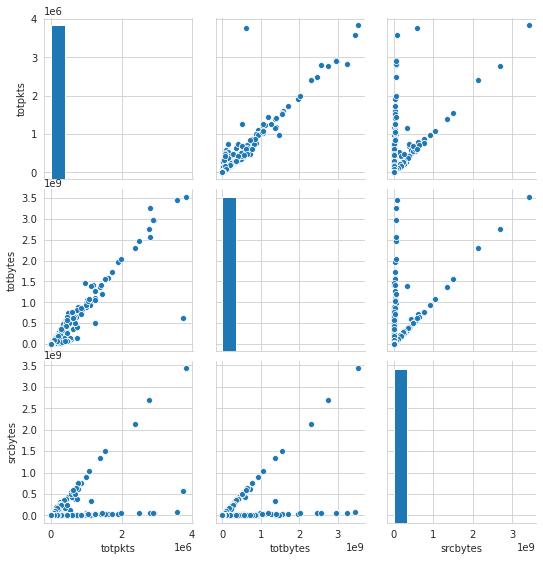

In [18]:
sns.set_style("whitegrid")
sns.pairplot(data=train, vars=['totpkts', 'totbytes', 'srcbytes'])
plt.show()

### Countplots and pdf of features

### Utility functions

In [19]:
def col_countplot(col, train_data=train):
    """
    This function plots countplot of a given feature for train dataset
    """
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=col, hue='target', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [20]:
# Plotting pdf of numerical columns

def dual_plot(col, data1=normal, data2=anomaly, label1='normal', label2='anomaly', method=None):
    """
    This function plots pdf of the given feature on attack and non-attck data
    """
    if method != None:
        sns.set_style('whitegrid')
        sns.distplot(data1[col].apply(method), label=label1, hist=False, rug=True)
        sns.distplot(data2[col].apply(method), label=label2, hist=False, rug=True)
    else:
        sns.set_style('whitegrid')
        sns.distplot(data1[col], label=label1, hist=False, rug=True)
        sns.distplot(data2[col], label=label2, hist=False, rug=True)
    plt.legend()

In [21]:
def reduce_column(s, to_keep):
    """
    This function reduce categorical values of a given feature to values provided in to_keep list
    and make every other value "others"
    """
    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

#### Attack Category
The name of each attack category. In this
data set, there are total eight categories of attack and normal is non-attack.

The data is highly imbalanced and have lots of non-attack than attacks.


In train data most occured attack data categories are "Neris", "Rbot", "Virut", "DonBot", "Sogou", "Murlo" and "NSIS.ay"

In [22]:
anomaly.label.value_counts()

flow=From-Botnet-V44-TCP-Attempt                     18369
flow=From-Botnet-V54-TCP-Attempt                     15714
flow=From-Botnet-V50-1-UDP-DNS                       10627
flow=From-Botnet-V50-7-UDP-DNS                        8840
flow=From-Botnet-V51-6-ICMP                           8187
                                                     ...  
flow=From-Botnet-V45-TCP-Established-HTTP-Ad-4           1
flow=From-Botnet-V51-8-TCP-CC1-HTTP-Not-Encrypted        1
flow=From-Botnet-V50-5-TCP-CC7-Custom-Encryption         1
flow=From-Botnet-V50-9-TCP-Established-HTTP-Ad-52        1
flow=From-Botnet-V50-7-TCP-Established-HTTP-Ad-53        1
Name: label, Length: 1009, dtype: int64

#### Proto
Categorical feature. Transaction protocol


1. Most of the values are consists of udp and tcp
2. Special, for attacks count of tcp is lot higher
3. Considering the imbalce there are lots of udp cat for attacks

In [23]:
train.proto.nunique()

18

In [24]:
train.proto.value_counts()

udp          7298615
tcp          2334205
icmp          280538
igmp           19079
arp             6452
rtp             6150
rtcp            4961
ipv6-icmp        689
ipx/spx          162
ipv6              75
udt               21
esp               16
unas              10
rarp               8
llc                5
rsvp               3
pim                2
ipnip              1
Name: proto, dtype: int64

In [25]:
normal['proto'].nunique(), anomaly['proto'].nunique()

(18, 3)

In [26]:
anomaly['proto'].value_counts()

tcp     100755
udp      81578
icmp     74590
Name: proto, dtype: int64

In [27]:
train['proto'].value_counts()*100/train.shape[0]

udp          73.345602
tcp          23.457008
icmp          2.819196
igmp          0.191730
arp           0.064838
rtp           0.061803
rtcp          0.049854
ipv6-icmp     0.006924
ipx/spx       0.001628
ipv6          0.000754
udt           0.000211
esp           0.000161
unas          0.000100
rarp          0.000080
llc           0.000050
rsvp          0.000030
pim           0.000020
ipnip         0.000010
Name: proto, dtype: float64

In [28]:
to_keep = ['tcp', 'udp', 'icmp', 'igmp', 'rtp']
train['proto_reduced'] = train['proto'].apply(reduce_column, args=(to_keep,))

In [29]:
train.proto_reduced.value_counts()

udp       7298615
tcp       2334205
icmp       280538
igmp        19079
others      12405
rtp          6150
Name: proto_reduced, dtype: int64

In [30]:
anomaly['proto_reduced'] = anomaly['proto'].apply(reduce_column, args=(to_keep,))

In [31]:
anomaly.proto_reduced.value_counts()

tcp     100755
udp      81578
icmp     74590
Name: proto_reduced, dtype: int64

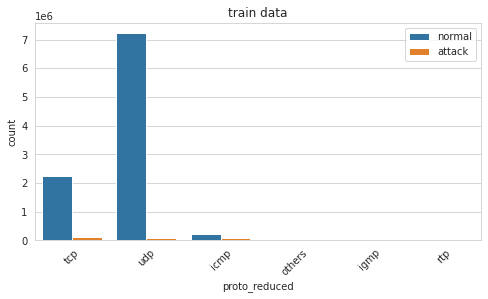

In [32]:
col_countplot('proto_reduced')

#### Direction
Categorical Features


1. Directions have three categories: forward, backward, bidirection
2. Attack dir is always forward or bidirection not backward

In [33]:
train.dir.value_counts()

  <->    7041896
   ->    2754519
  <-      100205
  <?>      29377
   ?>      18516
  who       6460
  <?          19
Name: dir, dtype: int64

In [34]:
train['dir'].value_counts()*100/train.shape[0]

  <->    70.765769
   ->    27.680848
  <-      1.006985
  <?>     0.295217
   ?>     0.186072
  who     0.064918
  <?      0.000191
Name: dir, dtype: float64

In [35]:
anomaly['dir'].value_counts()*100/anomaly.shape[0]

   ->    68.441907
  <->    31.539411
  <?>     0.018683
Name: dir, dtype: float64

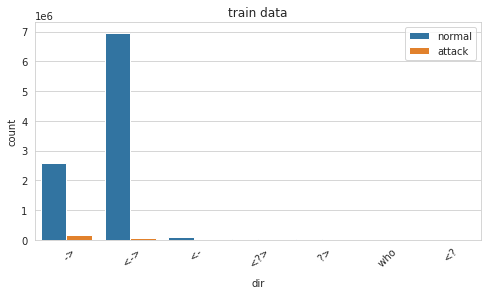

In [36]:
col_countplot('dir')

#### Service
Categorical Features


#### Stos, Dtos

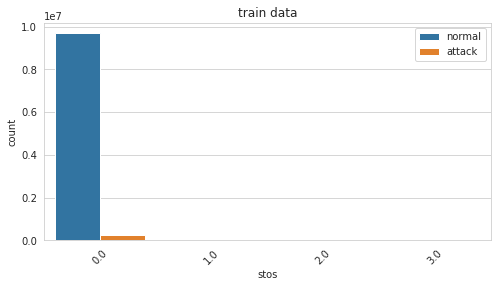

In [37]:
col_countplot('stos')

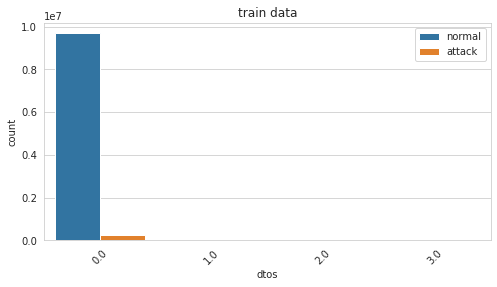

In [38]:
col_countplot('dtos')

#### State
Categorical feature. The state and its dependent protocol

Reducing very rare values with "others" to plot and visualize better

1. For non-attacks "con" is very frequent then "fspa_fspa" and few "int" also.
2. In attack "s_" is nearly normal cat values. That could be really important feature to detect. There are very few "s_"

In [39]:
train['state'].nunique()

408

In [40]:
train['state'].value_counts().head(20)

CON           7033000
FSPA_FSPA     1084355
INT            297007
S_             258557
S_RA           250211
SRPA_FSPA      123724
FSA_FSA        101210
SRPA_SPA        70509
FSRPA_FSPA      67439
RED             64714
UNK             60732
SA_             57044
URP             50576
ECR             43830
FSPA_FSRPA      31131
ECO             26654
S_SA            26631
_FSPA           23919
PA_PA           21557
SA_R            15642
Name: state, dtype: int64

In [41]:
to_keep = ['con', 'fspa_fspa', 'int', 's_', 's_ra', 'srpa_fspa', 'fsa_fsa']
train['state_reduced'] = train['state'].apply(reduce_column, args=(to_keep,))

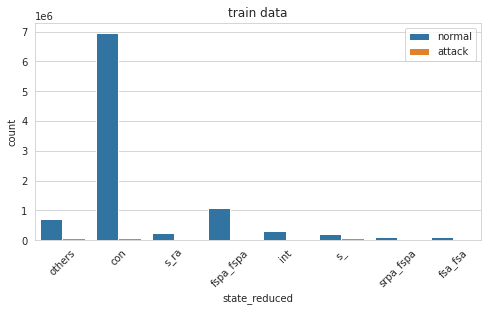

In [42]:
col_countplot('state_reduced')

In [43]:
train.drop(columns=['proto_reduced', 'state_reduced'], inplace=True)

In [44]:
train

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label,target
0,2011-08-12 22:08:41.277072,0.000000,tcp,74.86.42.203,80,->,147.32.86.50,3072,SA_,0.0,0.0,1,60,60,flow=Background-TCP-Established,0
1,2011-08-14 23:11:07.462572,0.003940,udp,67.49.33.55,53622,<->,147.32.84.229,13363,CON,0.0,0.0,4,2995,60,flow=Background-UDP-Established,0
2,2011-08-15 14:02:41.946307,0.000289,udp,147.32.86.171,56559,<->,147.32.80.9,53,CON,0.0,0.0,2,392,77,flow=To-Background-UDP-CVUT-DNS-Server,0
3,2011-08-16 08:46:24.544795,1336.481934,udp,77.87.33.112,35057,<->,147.32.84.229,13363,CON,0.0,0.0,4,1138,150,flow=Background-UDP-Established,0
4,2011-08-18 10:41:28.980563,0.984197,tcp,84.122.159.122,1958,->,147.32.84.118,6881,S_RA,0.0,0.0,6,366,186,flow=Background-TCP-Attempt,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950987,2011-08-15 01:55:47.339228,0.000598,udp,74.65.181.205,42064,<->,147.32.84.229,13363,CON,0.0,0.0,2,552,75,flow=Background-UDP-Established,0
9950988,2011-08-16 04:08:02.954859,0.000469,udp,147.32.86.20,53758,<->,147.32.80.9,53,CON,0.0,0.0,2,239,79,flow=To-Background-UDP-CVUT-DNS-Server,0
9950989,2011-08-12 23:48:40.386105,0.000147,tcp,157.55.185.43,61000,->,147.32.85.100,41598,S_RA,0.0,0.0,2,126,66,flow=Background-TCP-Attempt,0
9950990,2011-08-17 13:07:44.185185,0.000253,udp,147.32.84.138,40794,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0


In [45]:
train.shape

(9950992, 16)

#### SourcePort, DestPort

They are numerical features

In [ ]:
sns.boxplot(x='target', y='sport', data=train)

#### totpkt
Numerical feature. Total packets are exchanged on time (mSec)

1. Feature has large range of values upto 17m packet
2. For normal dataset there is high peek from 0 - 2.5m packet
3. And for attack data all the values are very close to 0 and  distribution of values are very narrow.
3. We can visualize better in log scale

In [46]:
train['totpkts'].value_counts()

2        6180227
4         695800
1         383825
6         349064
10        266116
          ...   
18747          1
13232          1
10550          1
21439          1
10045          1
Name: totpkts, Length: 9990, dtype: int64

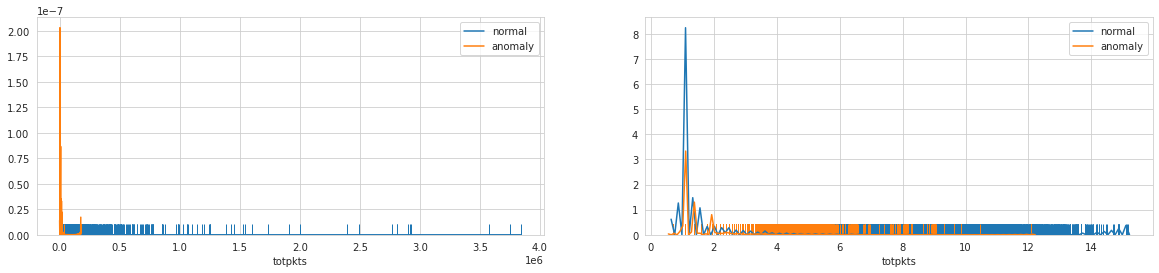

In [47]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('totpkts')
plt.subplot(122)
dual_plot('totpkts', method=np.log1p)
plt.show()

#### totbytes
Numerical feature.
<br>
Total packets are exchanged on time (mSec)


1. Feature has large range of values upto 4.5*1e9
2. For nonmal data there is a very high peek from 0 to 1*1e9
3. And for attack data all the values are very close to 0 and distribution of values are very narrow.

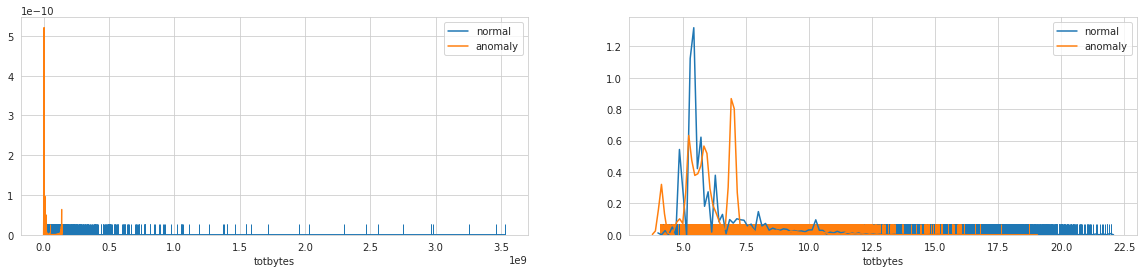

In [48]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('totbytes')
plt.subplot(122)
dual_plot('totbytes', method=np.log1p)
plt.show()

#### srcbytes
Numerical feature. Source Byte (mSec)
1. Range of this feature is huge upto 9*1e8.
2. Nbnormal data distributed over very wide range upto 100,000,000.
3. For attack data there is a huge peek close to 0 and 100,000,000 moreover distributioon of values are very narrow.
4. In log high peeks from 0 - 20% percentline of data distribution

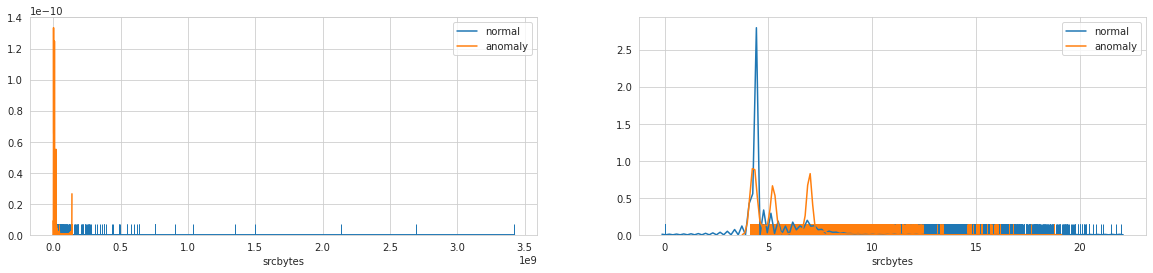

In [49]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('srcbytes')
plt.subplot(122)
dual_plot('srcbytes', method=np.log1p)
plt.show()

#### dur
Numerical feature. Record total duration
1. Range of this feature is 0 to 3600
2. Both attack and non-attack cat values have many peeks..

In [53]:
col = 'dur'
train[col].nunique()

2723243

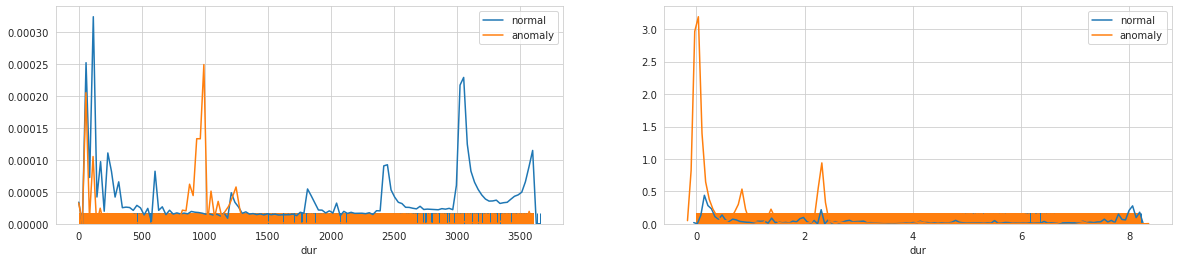

In [54]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

## Distribuiton of numerical feature

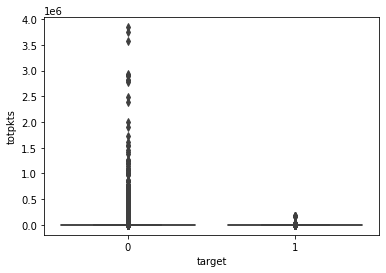

In [20]:
sns.boxplot(x='target', y='totpkts', data=train)

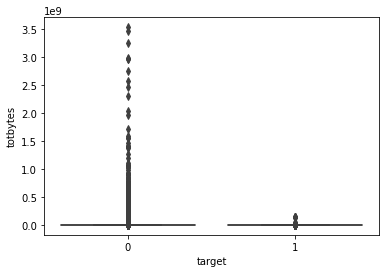

In [21]:
sns.boxplot(x='target', y='totbytes', data=train)

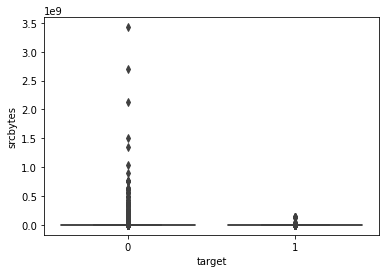

In [22]:
sns.boxplot(x='target', y='srcbytes', data=train)

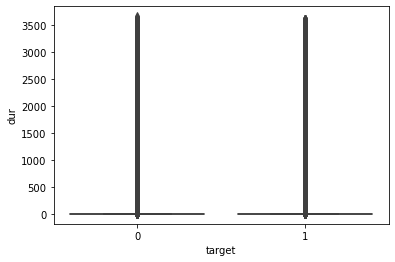

In [25]:
sns.boxplot(x='target', y='dur', data=train)

# Hypothesis Testing

In [10]:
sampletrain = train.sample(frac=1)[:1000000]

In [11]:
sampletrain.target.value_counts()

0    974223
1     25777
Name: target, dtype: int64

In [12]:
sampletrain.columns

Index(['starttime', 'dur', 'proto', 'srcaddr', 'sport', 'dir', 'dstaddr',
       'dport', 'state', 'stos', 'dtos', 'totpkts', 'totbytes', 'srcbytes',
       'label', 'target'],
      dtype='object')

In [13]:
sampletrain

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label,target
5915678,2011-08-17 04:06:21.112031,0.000315,udp,147.32.84.138,46451,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
9233478,2011-08-16 15:27:30.554841,0.000276,udp,147.32.84.138,46284,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
6164431,2011-08-16 15:00:09.982807,0.113908,udp,147.32.84.229,13363,<->,78.141.179.10,34050,CON,0.0,0.0,4,707,584,flow=Background-UDP-Established,0
3928343,2011-08-16 08:42:05.779347,0.000216,udp,147.32.84.138,45741,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
9273743,2011-08-13 19:41:06.835702,3348.979980,udp,46.116.225.208,7767,<->,147.32.84.229,13363,CON,0.0,0.0,14,1635,1201,flow=Background-UDP-Established,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907886,2011-08-14 13:29:01.605659,0.000492,udp,147.32.84.166,50912,<->,147.32.80.9,53,CON,0.0,0.0,2,304,83,flow=To-Background-UDP-CVUT-DNS-Server,0
5979294,2011-08-18 13:27:25.579768,0.000000,icmp,147.32.84.59,0x0303,->,81.157.236.218,0x5000,URP,0.0,0.0,1,89,89,flow=Background-Attempt-cmpgw-CVUT,0
9603900,2011-08-12 22:12:52.702025,0.207605,tcp,147.32.86.20,1287,->,188.138.84.239,80,FSPA_FSPA,0.0,0.0,39,30691,1029,flow=Background-TCP-Established,0
579878,2011-08-13 05:02:21.379621,0.000075,icmp,147.32.87.249,38043,<-,147.32.87.13,0x0002,ECR,0.0,0.0,2,148,0,flow=Background,0


In [14]:
numVariable = ['dur', 'sport', 'dport', 'totpkts', 'totbytes', 'srcbytes']

In [15]:
catVariable = ['prot', 'dir' , 'stos', 'dtos']

#### Numerical feature

### Totpkts

##### <font color='darkblue'>Bước 1:</font> Đặt giả thiết 2 mẫu độc lập, 2 tổng thể tuân theo phân bố chuẩn
###### 1.a Kiểm định phương sai của hai tổng thể $Nonrmal = X \sim N(µ_1, σ_1^2)$ và $Abnormal = Y \sim N(µ_2, σ^2_2)$

###### 1.b Giả thuyết: $H_0 : σ^2_1 = σ^2_2$ với đối thuyết $H_1 : σ^2_1 \neq σ^2_2$

###### 1.b Tính thống kê $F_{obs} = \frac{S_1^2}{S_2^2}$ ~ $Fisher$ $ n-1, m-1$ do đang kiểm định $H_0 : σ^2_1 = σ^2_2$

###### Nếu $F_{obs} > 1$ thì: $p_{value} = \mathbb{P}(F_{n-1, m-1} > F_{obs}) + \mathbb{P}(F_{n-1, m-1} <1/F_{obs})$

###### Nếu $F_{obs} < 1$ thì: $p_{value} = \mathbb{P}(F_{n-1, m-1} < F_{obs}) + \mathbb{P}(F_{n-1, m-1} >1/F_{obs})$

##### <font color='darkblue'>Bước 2:</font> Xây dựng cặp giả thuyết - đối giả thuyết: $H_0$:$σ^2_1 = σ^2_2$ , và $H_1$

##### <font color='darkblue'>Bước 3:</font> Tính toán giá trị thống kê và p_giá trị: dựa vào bài sampling để đưa ra phân bố phù hợp với $σ^2_1 = σ^2_2$ hoặc $σ^2_1 \neq σ^2_2$

###### Th1: $σ^2_1 = σ^2_2$ Thống kê $t_{obs} = \frac{\hat{X} - \hat{Y}}{\sqrt{S^2(\frac{1}{n} + \frac{1}{m})}} \sim t_{n + m - 2}$ do đang kiểm định $H_0: \mu_1 = \mu_2$

###### Với $S^2 = \frac{(n-1)S_1^2 + (m-1)S_2^2}{n + m -2}$

###### Th2: $σ^2_1 \neq σ^2_2$ Thống kê $t_{obs} = \frac{\hat{X} - \hat{Y}}{\sqrt{(\frac{S_1^2}{n} + \frac{S_2^2}{m})}} \sim t_{v}$ do đang kiểm định $H_0: \mu_1 = \mu_2$

###### Với $v = \frac{(\frac{S_1^2}{n} + \frac{S_2^2}{n})^2}{(\frac{S_1^2}{n})^2 /(n-1)  + \frac{S_2^2}{n})^2 /(m-1)}$


##### <font color='darkblue'>Bước 4:</font> đưa ra kết luận kiểm định

###### - đối thuyết $H_1: \mu_1 > \mu_2: p_{value} = P(T_{n-1} > t_{obs})$ với $σ^2_1 = σ^2_2$
###### - đối thuyết $H_1: \mu_1 > \mu_2: p_{value} = P(T_{v} > t_{obs})$ với $σ^2_1 \neq σ^2_2$
###### - đối thuyết $H_1: \mu_1 < \mu_2: p_{value} = P(T_{n-1} < t_{obs})$ với $σ^2_1 = σ^2_2$
###### - đối thuyết $H_1: \mu_1 < \mu_2: p_{value} = P(T_{v} < t_{obs})$ với $σ^2_1 \neq σ^2_2$
###### - đối thuyết $H_1: \mu_1 \neq \mu_2: p_{value} = 2P(T_{n-1} > |t_{obs}|)$ với $σ^2_1 = σ^2_2$
###### - đối thuyết $H_1: \mu_1 \neq \mu_2: p_{value} = 2P(T_{v} > |t_{obs}|)$ với $σ^2_1 \neq σ^2_2$

###### <font color='darkblue'>Bước 5:</font> Kết luận


In [24]:
from scipy import stats

In [66]:
normal = sampletrain[sampletrain['target']==0]
abnormal = sampletrain[sampletrain['target']==1]

In [69]:
varTotPktsNormal = normal.totpkts.var()
varTotPktsAbnormal = abnormal.totpkts.var()

Fobs = varTotPktsNormal/varTotPktsAbnormal

In [70]:
Fobs

10.05710549984856

In [71]:
n, m = len(normal), len(abnormal)

In [72]:
p1 = 1 - stats.f.cdf(Fobs, n - 1, m - 1) + stats.f.cdf(1 / Fobs, n - 1, m - 1)

In [73]:
p1

1.1102230246251565e-16

#### Bác bỏ giả thuyết $H_0$ tức phương sai hai tổng thể khác nhau

In [74]:
meanTotPktsNormal = normal.totpkts.mean()
meanTotPktsAbnormal = abnormal.totpkts.mean()

In [75]:
tObs = (meanTotPktsNormal - meanTotPktsAbnormal) / np.sqrt(varTotPktsNormal / n + varTotPktsAbnormal / m)

In [76]:
nu = round((varTotPktsNormal / n + varTotPktsAbnormal / m)**2 / ((varTotPktsNormal / n)**2 / (n - 1) + (varTotPktsAbnormal / m)**2 / (m - 1)))
p2 = 2 * (1 - stats.t.cdf(np.abs(tObs), nu))

In [77]:
p2

0.05333768960989782

#### Không đủ bằng chứng để chứng minh trung bình số packet của hai mẫu là khác nhau

### Totbytes

In [78]:
varTotbytesNormal = normal.totbytes.var()
varTotbytesAbnormal = abnormal.totbytes.var()
Fobs = varTotbytesNormal/varTotbytesAbnormal

In [79]:
meanTotbytesNormal = normal.totbytes.mean()
meanTotbytesAbnormal  = abnormal.totbytes.mean()

In [80]:
p1 = 1 - stats.f.cdf(Fobs, n - 1, m - 1) + stats.f.cdf(1 / Fobs, n - 1, m - 1)
p1

1.1102230246251565e-16

#### Bác bỏ giả thuyết $H_0$ tức phương sai hai tổng thể khác nhau

In [81]:
tObs = (meanTotbytesNormal - meanTotbytesAbnormal) / np.sqrt(varTotbytesNormal / n + varTotbytesAbnormal / m)

In [82]:
nu = round((varTotbytesNormal / n + varTotbytesAbnormal / m)**2 / ((varTotbytesNormal / n)**2 / (n - 1) + (varTotbytesAbnormal / m)**2 / (m - 1)))
p2 = 2 * (1 - stats.t.cdf(np.abs(tObs), nu))

In [83]:
p2

0.08375062852996762

#### Không đủ bằng chứng để chứng minh trung bình số packet của hai mẫu là khác nhau

### srcbytes

In [87]:
varSrcbytesNormal = normal.srcbytes.var()
varSrcbytesAbnormal = abnormal.srcbytes.var()
Fobs = varSrcbytesNormal/varSrcbytesAbnormal

In [88]:
meanSrcbytesNormal = normal.srcbytes.mean()
meanSrcbytesAbnormal  = abnormal.srcbytes.mean()

In [89]:
p1 = 1 - stats.f.cdf(Fobs, n - 1, m - 1) + stats.f.cdf(1 / Fobs, n - 1, m - 1)
p1

1.1102230246251565e-16

#### Bác bỏ giả thuyết $H_0$ tức phương sai hai tổng thể khác nhau

In [90]:
tObs = (meanSrcbytesNormal - meanSrcbytesAbnormal) / np.sqrt(varSrcbytesNormal / n + varSrcbytesAbnormal / m)

In [91]:
nu = round((varSrcbytesNormal / n + varSrcbytesAbnormal / m)**2 / ((varSrcbytesNormal / n)**2 / (n - 1) + (varSrcbytesAbnormal / m)**2 / (m - 1)))
p2 = 2 * (1 - stats.t.cdf(np.abs(tObs), nu))

In [92]:
p2

0.34140428854253857

#### Không đủ bằng chứng để chứng minh trung bình số packet của hai mẫu là khác nhau

### Dur

In [95]:
varDurNormal = normal.dur.var()
varDurAbnormal = abnormal.dur.var()
Fobs = varDurNormal/varDurAbnormal

In [96]:
meanDurNormal = normal.dur.mean()
meanDurAbnormal  = abnormal.dur.mean()

In [97]:
p1 = 1 - stats.f.cdf(Fobs, n - 1, m - 1) + stats.f.cdf(1 / Fobs, n - 1, m - 1)
p1

1.1102230246251565e-16

#### Bác bỏ giả thuyết $H_0$ tức phương sai hai tổng thể khác nhau

In [98]:
tObs = (meanDurNormal - meanDurAbnormal) / np.sqrt(varDurNormal / n + varDurAbnormal / m)

In [99]:
nu = round((varDurNormal / n + varDurAbnormal / m)**2 / ((varDurNormal / n)**2 / (n - 1) + (varDurAbnormal / m)**2 / (m - 1)))
p2 = 2 * (1 - stats.t.cdf(np.abs(tObs), nu))

In [100]:
p2

0.0

#### đủ bằng chứng để chứng minh trung bình số packet của hai mẫu là khác nhau

### Catogorical feature

#### Dir

In [101]:
crosstab = pd.crosstab(sampletrain.dir, sampletrain.target)

In [102]:
crosstab

target,0,1
dir,,
->,258995,17596
?>,1857,0
<-,10132,0
<->,699681,8175
<?,5,0
<?>,2914,6
who,639,0


In [103]:
stats.chi2_contingency(crosstab, correction=True)

(21876.83745551953,
 0.0,
 6,
 array([[2.69461314e+05, 7.12968621e+03],
        [1.80913211e+03, 4.78678890e+01],
        [9.87082744e+03, 2.61172564e+02],
        [6.89609596e+05, 1.82464041e+04],
        [4.87111500e+00, 1.28885000e-01],
        [2.84473116e+03, 7.52688400e+01],
        [6.22528497e+02, 1.64715030e+01]]))

#### Hai feature Dir và Target độc lập

### proto

In [105]:
crosstab = pd.crosstab(sampletrain.proto, sampletrain.target)
crosstab

target,0,1
proto,,
arp,639,0
esp,4,0
icmp,20622,7526
igmp,1891,0
ipv6,4,0
ipv6-icmp,68,0
ipx/spx,17,0
llc,1,0
rtcp,457,0


In [106]:
stats.chi2_contingency(crosstab, correction=True)

(74398.59662307934,
 0.0,
 12,
 array([[6.22528497e+02, 1.64715030e+01],
        [3.89689200e+00, 1.03108000e-01],
        [2.74224290e+04, 7.25570996e+02],
        [1.84225569e+03, 4.87443070e+01],
        [3.89689200e+00, 1.03108000e-01],
        [6.62471640e+01, 1.75283600e+00],
        [1.65617910e+01, 4.38209000e-01],
        [9.74223000e-01, 2.57770000e-02],
        [4.45219911e+02, 1.17800890e+01],
        [5.80636908e+02, 1.53630920e+01],
        [2.28639422e+05, 6.04957835e+03],
        [7.14573086e+05, 1.89069140e+04],
        [5.84533800e+00, 1.54662000e-01]]))

### stos

In [107]:
crosstab = pd.crosstab(sampletrain.stos, sampletrain.target)
crosstab

target,0,1
stos,,
0.0,973396,25777
1.0,145,0
2.0,163,0
3.0,519,0


In [108]:
stats.chi2_contingency(crosstab, correction=True)

(21.89973263781587,
 6.844089212834387e-05,
 3,
 array([[9.73417318e+05, 2.57556824e+04],
        [1.41262335e+02, 3.73766500e+00],
        [1.58798349e+02, 4.20165100e+00],
        [5.05621737e+02, 1.33782630e+01]]))

### dtos

In [111]:
crosstab = pd.crosstab(sampletrain.dtos, sampletrain.target)
crosstab

target,0,1
dtos,,
0.0,974077,25777
1.0,7,0
2.0,66,0
3.0,73,0


In [110]:
stats.chi2_contingency(crosstab, correction=True)

(3.8635831249777968,
 0.2765764669243943,
 3,
 array([[9.74080763e+05, 2.57732366e+04],
        [6.81956100e+00, 1.80439000e-01],
        [6.42987180e+01, 1.70128200e+00],
        [7.11182790e+01, 1.88172100e+00]]))

#####  Hai biến phụ thuộc